# Project 1

### Betsy Rosalen and Mikhail Groysman

## Project Overview

For your first project, you are asked to

1. Identify and load a network dataset that has some categorical information available for each node.
2. For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
3. Compare your centrality measures across your categorical groups.

For example, using the dataset from a study of romantic relationships among high school students in Columbus, Ohio [http://researchnews.osu.edu/archive/chains.htm], you might want to determine if there are any differences in your calculated centrality measures between the two sexes.  You might use a t-test or another statistical measure to support your findings.

## Choosing the data

We chose a classical transportation network of __flight data from [OpenFlights.org](https://openflights.org/data.html)__.

__OpenFlights describes itself as:__

_"OpenFlights is a tool that lets you map your flights around the world, search and filter them in all sorts of interesting ways, calculate statistics automatically, and share your flights and trips with friends and the entire world (if you wish)."_

__OpenFlights consists of the following datasets:__

- Airports
- Airlines
- Routes
- Planes
- Schedules

We have choosen to use the __Routes__ and __Airports__ datasets to build our network. 

__Variables in the Routes dataset:__

- Airline
- Airline ID
- Source Airport
- Source Airport ID
- Destination Airport
- Destination Airport ID
- Codeshare
- Stops
- Equipment

__Variables in the Airports dataset:__

- Airport ID
- Name
- City
- Country
- IATA
- ICAO
- Latitude
- Longtitude
- Altitude
- Timezone
- DST
- Tz database time zone
- Type
- Source

Our nodes will be taken from the __Source Airport__ and __Destination Airport__ variables in the __Routes__ dataset. Each record with a source and destination airport represents an edge between nodes and the __Stops__ variable could be used as an optional edge weight.

Data is saved as .DAT files. They are UTF-8 encoded.

There's a bit too much data for us to process, so we are going to focus our analysis on the Western Hemisphere only. 

## Choosing a Categorical Variable

We have decided to create a categorical variable __Hemisphere__ from the __Latitude__ variable in the __Airports__ dataset.  An airport node with a Negative latitude will be coded __S for "South"__, and an airport node with a positive latitude will be coded __N for "North"__.

## Loading the data

First import necessary packages for plotting graphs using NetworkX and Matplotlib and set up graph size parameters...

In [107]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

Read in __Routes__ data to a Pandas dataframe.

In [108]:
routes_raw = pd.read_csv("Project1_Data/routes.dat", 
                       header=None, sep=",", 
                       usecols=[2, 4, 7], 
                       names=['Source Airport','Destination Airport', 'Stops'])
routes_raw.head()

Source Airport Destination Airport  Stops
0            AER                 KZN      0
1            ASF                 KZN      0
2            ASF                 MRV      0
3            CEK                 KZN      0
4            CEK                 OVB      0

Read in the __Airports__ data to a Pandas dataframe.

In [109]:
airports_raw = pd.read_csv("Project1_Data/airports.dat", 
                       header=None, sep=",", 
                       usecols=[1, 2, 3, 4, 6, 7], 
                       names=['Airport Name','City','Country','IATA', 'Latitude', 'Longitude'])
airports_raw.head()

Airport Name          City  \
0                               Goroka Airport        Goroka   
1                               Madang Airport        Madang   
2                 Mount Hagen Kagamuga Airport   Mount Hagen   
3                               Nadzab Airport        Nadzab   
4  Port Moresby Jacksons International Airport  Port Moresby   

            Country IATA  Latitude   Longitude  
0  Papua New Guinea  GKA -6.081690  145.391998  
1  Papua New Guinea  MAG -5.207080  145.789001  
2  Papua New Guinea  HGU -5.826790  144.296005  
3  Papua New Guinea  LAE -6.569803  146.725977  
4  Papua New Guinea  POM -9.443380  147.220001

As stated above, there's too much data for us to process, so we are going to focus our analysis on the Western Hemisphere only by filtering out all airports in the Eastern Hemisphere using the Longitude.

In [110]:
airports_raw = airports_raw[airports_raw.Longitude<0]
airports_raw.head()

Airport Name          City    Country IATA   Latitude  \
6        Narsarsuaq Airport  Narssarssuaq  Greenland  UAK  61.160500   
7   Godthaab / Nuuk Airport      Godthaab  Greenland  GOH  64.190903   
8     Kangerlussuaq Airport   Sondrestrom  Greenland  SFJ  67.012222   
9            Thule Air Base         Thule  Greenland  THU  76.531197   
10         Akureyri Airport      Akureyri    Iceland  AEY  65.660004   

    Longitude  
6  -45.425999  
7  -51.678101  
8  -50.711603  
9  -68.703201  
10 -18.072701

## Transforming the Data

### Create categorical variable

First let's code each airport in the Airports dataframe with 'N' or 'S' for our categorical variable, Hemisphere...

In [111]:
airports_raw['Hemisphere'] = np.where(airports_raw['Latitude'] >=0, 'N', 'S')
airports_raw[4:8]

Airport Name         City  Country IATA   Latitude  Longitude  \
10      Akureyri Airport     Akureyri  Iceland  AEY  65.660004 -18.072701   
11   Egilsstaðir Airport  Egilsstadir  Iceland  EGS  65.283302 -14.401400   
12  Hornafjörður Airport         Hofn  Iceland  HFN  64.295601 -15.227200   
13       Húsavík Airport      Husavik  Iceland  HZK  65.952301 -17.426001   

   Hemisphere  
10          N  
11          N  
12          N  
13          N

In [112]:
len(airports_raw)

3559

### Create Node List

Let's check if all the same airports are listed in both the source and destination airports of the routes data.

In [113]:
set(routes_raw['Source Airport']) == set(routes_raw['Destination Airport'])

False

In [114]:
len(routes_raw['Source Airport'].unique())

3409

In [115]:
len(routes_raw['Destination Airport'].unique())

3418

Apparently they are not the same, so let's take the union of the two sets to make our list of nodes.

In [116]:
airport_nodes = set(routes_raw['Source Airport']) | set(routes_raw['Destination Airport'])
len(airport_nodes)

3425

Now we need to convert it back to a pandas dataframe so we can merge it with the airports data to get the Hemisphere categorical variable added as an attribute of our nodes.  At the same time this will filter out the Airports that are in the Eastern Hemisphere because they are not in our Airports list anymore.  

In [117]:
airport_nodes = pd.DataFrame(airport_nodes, columns = ['IATA'])
airport_nodes = pd.merge(airport_nodes, airports_raw, on='IATA', how='inner')
airport_nodes.head()

IATA                                 Airport Name           City  \
0  TBP    Capitan FAP Pedro Canga Rodriguez Airport         Tumbes   
1  BLK              Blackpool International Airport      Blackpool   
2  SBA              Santa Barbara Municipal Airport  Santa Barbara   
3  VCP              Viracopos International Airport       Campinas   
4  AYP  Coronel FAP Alfredo Mendivil Duarte Airport       Ayacucho   

          Country   Latitude   Longitude Hemisphere  
0            Peru  -3.552530  -80.381401          S  
1  United Kingdom  53.771702   -3.028610          N  
2   United States  34.426201 -119.839996          N  
3          Brazil -23.007401  -47.134499          S  
4            Peru -13.154800  -74.204399          S

In [118]:
len(airport_nodes)

1472

We seem to have lost almost 2000 records in the join, so we will have to remove edges for which we have no nodes since they will not have Hemisphere data.

### Create Edge List

We already have our edge list.  It's the __routes_raw__ dataframe we created above when we imported the routes data.  We just need to filter out any edges that contain the nodes that we don't have Hemisphere data for as noted above or that are in the Eastern Hemisphere by merging the routes data with the airport_nodes data.

In [119]:
routes_raw.head()

Source Airport Destination Airport  Stops
0            AER                 KZN      0
1            ASF                 KZN      0
2            ASF                 MRV      0
3            CEK                 KZN      0
4            CEK                 OVB      0

In [120]:
len(routes_raw)

67663

Let's do an inner join on the airports and routes to remove routes with missing airport nodes.

In [121]:
routes_merged1 = pd.merge(routes_raw,airport_nodes[['IATA']],left_on='Source Airport',right_on='IATA',how='inner')
routes_merged2 = pd.merge(routes_merged1,airport_nodes[['IATA']],left_on='Destination Airport',right_on='IATA',how='inner')
routes = routes_merged2.loc[:, 'Source Airport':'Stops']
routes.head()

Source Airport Destination Airport  Stops
0            AYP                 LIM      0
1            AYP                 LIM      0
2            CUZ                 LIM      0
3            CUZ                 LIM      0
4            CUZ                 LIM      0

In [122]:
len(routes)

22418

Looks like we lost about 45,000 routes that did not have hemisphere data or that were in the Eastern hemisphere leaving us with a litte under over 22,500 remaining routes or edges for our graph.

## Create NetworkX Graph Object

I used code from this stackoverflow post to figure out how to import the data directly from our pandas dataframes to a networkx graph object...

https://stackoverflow.com/questions/42558165/load-nodes-with-attributes-and-edges-from-dataframe-to-networkx

In [123]:
g = nx.from_pandas_edgelist(routes, 'Source Airport', 'Destination Airport', True, nx.DiGraph())
nx.set_node_attributes(g, airport_nodes.set_index('IATA').to_dict('index'))

Let's double check if our attributes were saved in the graph data.

In [124]:
g.node['AYP']

{'Airport Name': 'Coronel FAP Alfredo Mendivil Duarte Airport',
 'City': 'Ayacucho',
 'Country': 'Peru',
 'Latitude': -13.154800415039062,
 'Longitude': -74.20439910888672,
 'Hemisphere': 'S'}

In [125]:
g.get_edge_data('CUZ','LIM')

{'Source Airport': 'CUZ', 'Destination Airport': 'LIM', 'Stops': 0}

## Calculate Degree Centrality

In [126]:
deg = nx.degree(g)

In [127]:
deg_df = pd.DataFrame(deg, columns = ['IATA', 'Deg_Centrality'])
deg_df = pd.merge(deg_df, airports_raw, on='IATA', how='inner')
sorted_deg = deg_df.sort_values('Deg_Centrality', ascending = False)
sorted_deg.head()

IATA  Deg_Centrality                                      Airport Name  \
14   ATL             405  Hartsfield Jackson Atlanta International Airport   
67   ORD             363              Chicago O'Hare International Airport   
18   DFW             358           Dallas Fort Worth International Airport   
169  DEN             331                      Denver International Airport   
41   IAH             313      George Bush Intercontinental Houston Airport   

                  City        Country   Latitude   Longitude Hemisphere  
14             Atlanta  United States  33.636700  -84.428101          N  
67             Chicago  United States  41.978600  -87.904800          N  
18   Dallas-Fort Worth  United States  32.896801  -97.038002          N  
169             Denver  United States  39.861698 -104.672997          N  
41             Houston  United States  29.984400  -95.341400          N

In [128]:
sorted_deg.tail()

IATA  Deg_Centrality                Airport Name                City  \
639   TTA               1             Tan Tan Airport             Tan Tan   
1254  MLY               1  Manley Hot Springs Airport  Manley Hot Springs   
1393  BVS               1              Breves Airport              Breves   
1394  SXX               1  São Félix do Xingu Airport  Sao Felix do Xingu   
1202  TLJ               1       Tatalina LRRS Airport            Tatalina   

            Country   Latitude   Longitude Hemisphere  
639         Morocco  28.448200  -11.161300          N  
1254  United States  64.997597 -150.643997          N  
1393         Brazil  -1.636530  -50.443600          S  
1394         Brazil  -6.641300  -51.952300          S  
1202  United States  62.894402 -155.977005          N

Interestingly the highest degree centrality was for northern airports only (all in USA), while the lowest degree centrality values are also only for Northern airports as well .

### Degree Centrality for Northern vs. Southern Hemisphere

In [129]:
deg_df.iloc[:, [0,1,7]].groupby(['Hemisphere']).describe().reset_index()

Hemisphere Deg_Centrality                                                  
                      count       mean        std  min  25%  50%   75%    max
0          N         1180.0  18.287288  40.633842  1.0  2.0  5.0  14.0  405.0
1          S          267.0  10.588015  18.611853  1.0  2.0  4.0   9.5  153.0

Northern Hemisphere airports on average have almost 2 times higher degree centrality than Southern Hemisphere ones. The top airport in the North had 405 connections vs only 153 for the top airport in the South.

#### Distribution of Degree Centrality in Northern vs. Southern Hemisphere

In [130]:
degN = deg_df[deg_df.Hemisphere=='N']
degS = deg_df[deg_df.Hemisphere=='S']

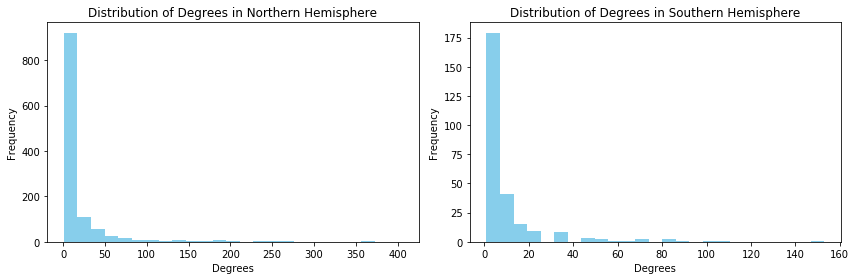

In [131]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(degN['Deg_Centrality'], 25, color = "skyblue")
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Distribution of Degrees in Northern Hemisphere')

plt.subplot(1, 2, 2)
plt.hist(degS['Deg_Centrality'], 25, color = "skyblue")
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Distribution of Degrees in Southern Hemisphere')

plt.tight_layout()
plt.show()

The shape of the two distributions is almost the same, but the range is very different with the Northern Hemisphere ranging from 1 to 400 with the vast majority of values falling in the 1 to 50 range and the Southern Hemisphere ranging from 1 to only 160 with the vast majority of values falling in the 1 to 20 range.  

## Calculate Eigenvector Centrality

In [132]:
eig = nx.eigenvector_centrality(g)

In [133]:
eig_df = pd.DataFrame.from_dict(eig, orient='index').reset_index()
eig_df.columns = ['IATA', 'Eig_Centrality']
eig_df = pd.merge(eig_df, airports_raw, on='IATA', how='inner')
sorted_eig = eig_df.sort_values('Eig_Centrality', ascending = False)
sorted_eig.head()

IATA  Eig_Centrality                                      Airport Name  \
14  ATL        0.197612  Hartsfield Jackson Atlanta International Airport   
67  ORD        0.187377              Chicago O'Hare International Airport   
18  DFW        0.181768           Dallas Fort Worth International Airport   
41  IAH        0.167516      George Bush Intercontinental Houston Airport   
37  EWR        0.166112              Newark Liberty International Airport   

                 City        Country   Latitude  Longitude Hemisphere  
14            Atlanta  United States  33.636700 -84.428101          N  
67            Chicago  United States  41.978600 -87.904800          N  
18  Dallas-Fort Worth  United States  32.896801 -97.038002          N  
41            Houston  United States  29.984400 -95.341400          N  
37             Newark  United States  40.692501 -74.168701          N

In [134]:
sorted_eig.tail()

IATA  Eig_Centrality                Airport Name                City  \
1317  LUR    1.493337e-22  Cape Lisburne LRRS Airport       Cape Lisburne   
1394  SXX    1.493337e-22  São Félix do Xingu Airport  Sao Felix do Xingu   
1327  IGG    1.493337e-22             Igiugig Airport             Igiugig   
1282  JQE    1.493337e-22               Jaqué Airport               Jaqué   
1201  SLQ    1.493337e-22           Sleetmute Airport           Sleetmute   

            Country   Latitude   Longitude Hemisphere  
1317  United States  68.875099 -166.110001          N  
1394         Brazil  -6.641300  -51.952300          S  
1327  United States  59.324001 -155.901993          N  
1282         Panama   7.517780  -78.157204          N  
1201  United States  61.700500 -157.166000          N

Again, the top values are for Northern airports only (all located in USA), and the lowest values are for almost all Northern airports as well.

### Eigenvector Centrality for Northern vs. Southern Hemisphere

In [135]:
eig_df.iloc[:, [0,1,7]].groupby(['Hemisphere']).describe().reset_index()

Hemisphere Eig_Centrality                                              \
                      count      mean       std           min       25%   
0          N         1180.0  0.011517  0.026602  1.493337e-22  0.000137   
1          S          267.0  0.001665  0.005619  1.493337e-22  0.000062   

                                 
        50%       75%       max  
0  0.002140  0.008310  0.197612  
1  0.000147  0.000973  0.055050

Northern airports had on average, Eigenvector Centrality which was almost 7 times higher than Southern airports.

#### Distribution of Degree Centrality in Northern vs. Southern Hemisphere

In [136]:
eigN = eig_df[eig_df.Hemisphere=='N']
eigS = eig_df[eig_df.Hemisphere=='S']

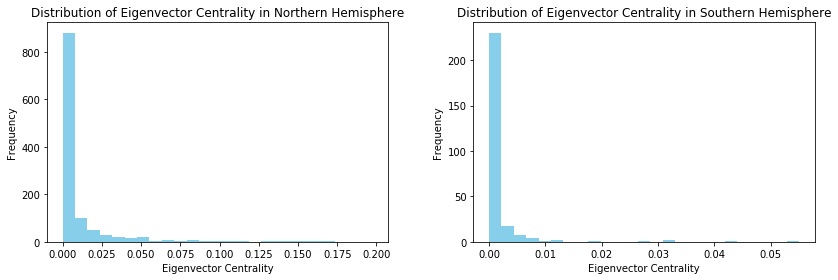

In [137]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(eigN['Eig_Centrality'], 25, color = "skyblue")
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Eigenvector Centrality in Northern Hemisphere')

plt.subplot(1, 2, 2)
plt.hist(eigS['Eig_Centrality'], 25, color = "skyblue")
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Eigenvector Centrality in Southern Hemisphere')

plt.tight_layout()
plt.show()

Once again, the shape of the two distributions is almost the same, but the range is very different with the Northern Hemisphere ranging from 0 to 0.05 with the vast majority of values falling in the 0 to 0.05 range and the Southern Hemisphere ranging from 0 to only 0.05 with the vast majority of values falling in the 0 to 0.01 range.  

## T-Test

Let's perform a T-test to see if difference in degree centrality and eigenvector centrality means for Northern and Southern airports is statistically significant. Our null hypothesis is that the mean of degree centrality is not statistically different between Northern and Southern airports and likewise that the mean of eigenvector centrality is not statistically different between Northern and Southern airports.

Let's calculate the T-value for degree centrality.

In [138]:
degN1 = degN.iloc[:,[1]]
degS1 = degS.iloc[:,[1]]

t_deg,p_deg = stats.ttest_ind(degN1.values,degS1.values)

t_deg

array([3.02453543])

That T-value corresponds to a p value of:

In [139]:
p_deg

array([0.00253407])

Based on the p-value, we can reject the null hypothesis. We have statistical evidences to claim that northern airports on average have significantly higher degree centrality than southern airports.

Let's test Eigenvector Centrality next.

In [140]:
eigN = eig_df[eig_df.Hemisphere=='N']
eigS = eig_df[eig_df.Hemisphere=='S']

t_eig, p_eig = stats.ttest_ind(eigN.iloc[:,1],eigS.iloc[:,1])

p_eig

2.21535891138162e-09

Based on the p value above, we can reject the null hypothesis and conclude that northern airports eigenvector centrality mean value is significantly different from the mean of southern airports.

## Visualize Air Routes Network

Admittedly this is not the best way to visualize this netework.  A graph that locates each node on a map would be better, and is a consideration for a future update. 

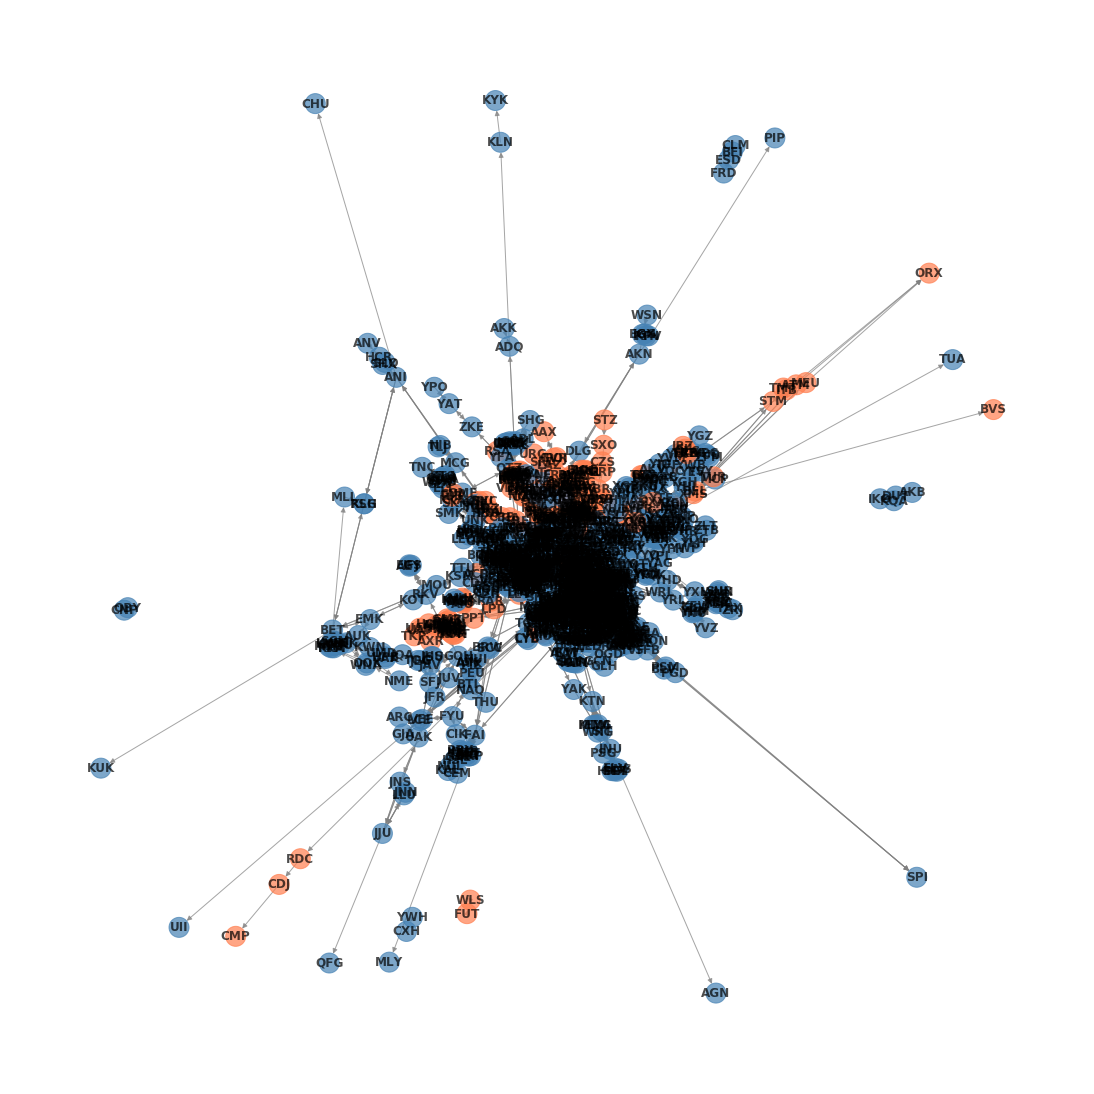

In [141]:
# set plot size
plt.rcParams["figure.figsize"] = (15,15)

# create empty list for node colors
colors = []

# for each node in the graph append the N or S color to the list
for node, data in g.nodes(data=True):
    if data['Hemisphere'] == 'N':
        colors.append('steelblue')         
    else:
        colors.append('coral')

# Draw the Graph
nx.draw(g, with_labels=True, node_size=400, node_color=colors, font_weight='bold', 
        edge_color="grey", alpha=0.7) 

Just for fun, let's separate out the northern and southern hemispheres and visualize them separately to see if that makes for a better visual comparison.  

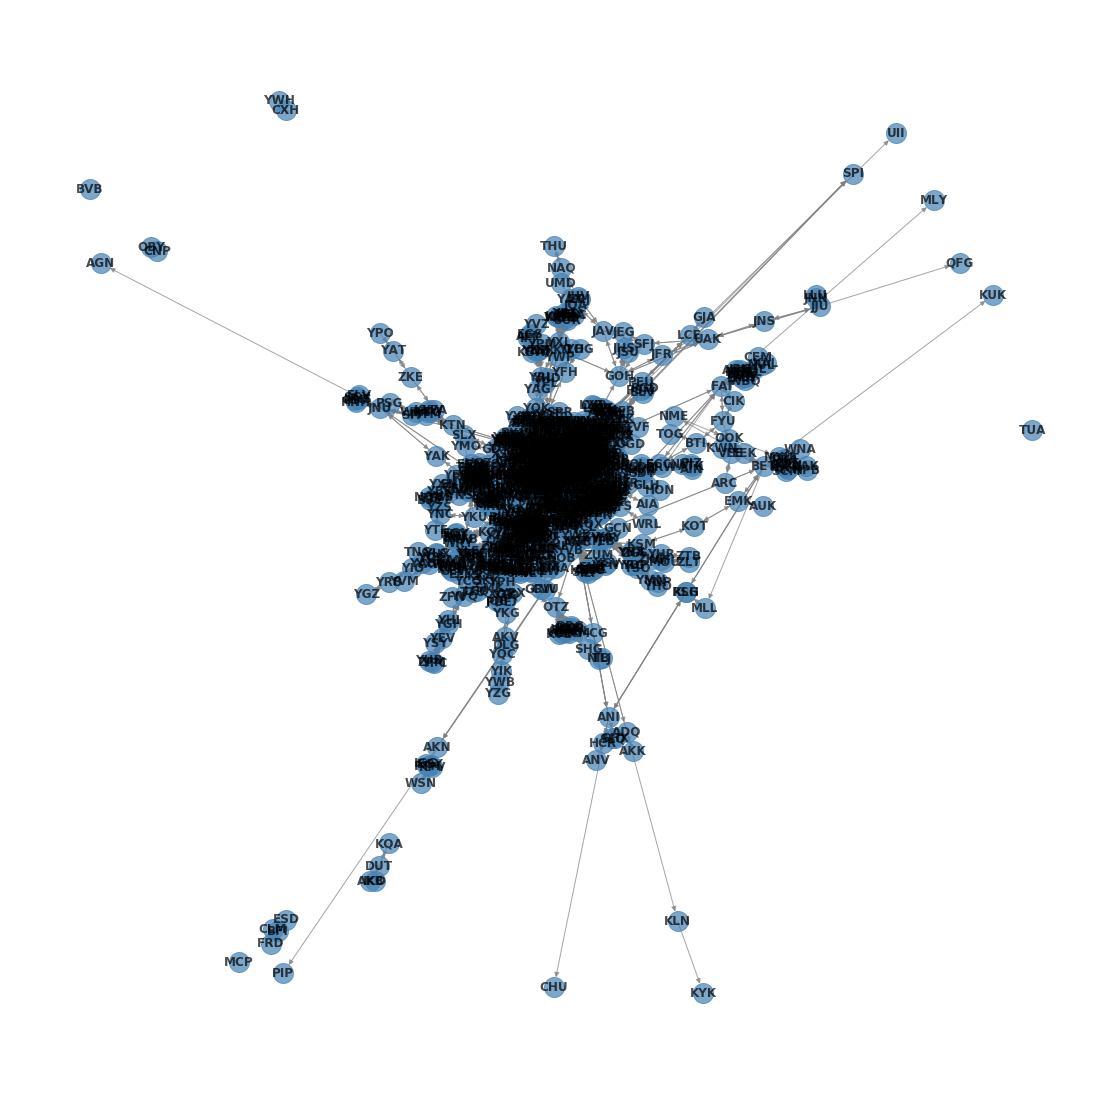

In [142]:
# set plot size
plt.rcParams["figure.figsize"] = (15,15)

H = g.subgraph(list(degN['IATA']))

# Draw the Graph
nx.draw(H, with_labels=True, node_size=400, node_color='steelblue', font_weight='bold', 
        edge_color="grey", alpha=0.7) 

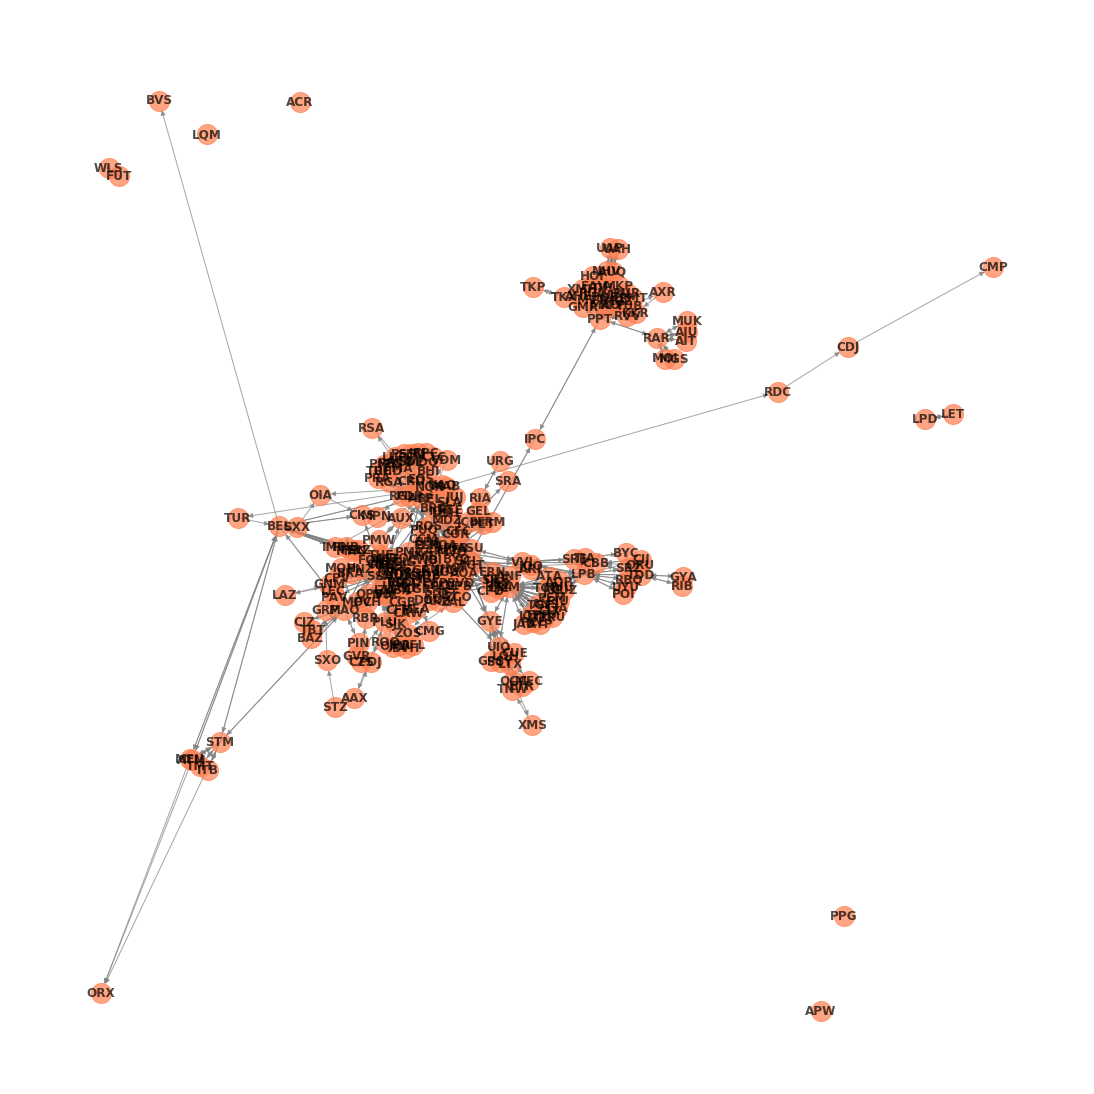

In [143]:
# set plot size
plt.rcParams["figure.figsize"] = (15,15)

I = g.subgraph(list(degS['IATA']))

# Draw the Graph
nx.draw(I, with_labels=True, node_size=400, node_color='coral', font_weight='bold', 
        edge_color="grey", alpha=0.7) 

## YouTube Video Presentation Link

https://www.youtube.com/watch?v=LNZpDo-YVtg